In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, log_loss
import itertools

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

### Кейс 2 - определение ССЗ

ссылка на соревнование - https://mlbootcamp.ru/ru/round/12/sandbox/

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [2]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [3]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [4]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [5]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор и запустим кросс-валидацию

Первым попробуем LR

In [6]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7867401104915408+-0.00852135511666111


In [7]:
b=1

def summary_metrics(name, y_score, y_test):
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    ix = np.argmax(fscore)
    roc_auc_sc = roc_auc_score(y_test, y_score)
    log_loss_sc = log_loss(y_test, y_score)
    result = (name, round(thresholds[ix], 2), round(fscore[ix], 2), round(precision[ix], 2), round(recall[ix], 2),\
              round(roc_auc_sc, 2), round(log_loss_sc, 2))
    return result

Запишем наши метрики

In [8]:
logreg = summary_metrics('LogisticRegression', y_score, y_test)

Нарисуем roc auc кривую

In [9]:
def draw_roc_auc_curve(y_test, y_score):    
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show()

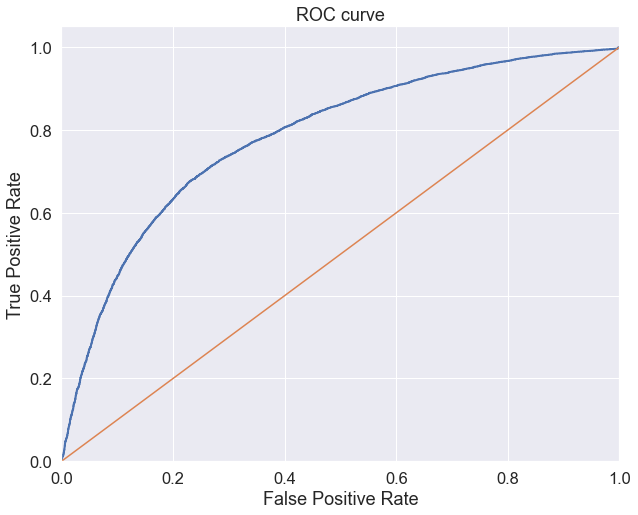

In [10]:
draw_roc_auc_curve(y_test, y_score)

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Посмотрим на матрицу ошибок

Confusion matrix, without normalization
[[4915 3905]
 [1463 7217]]


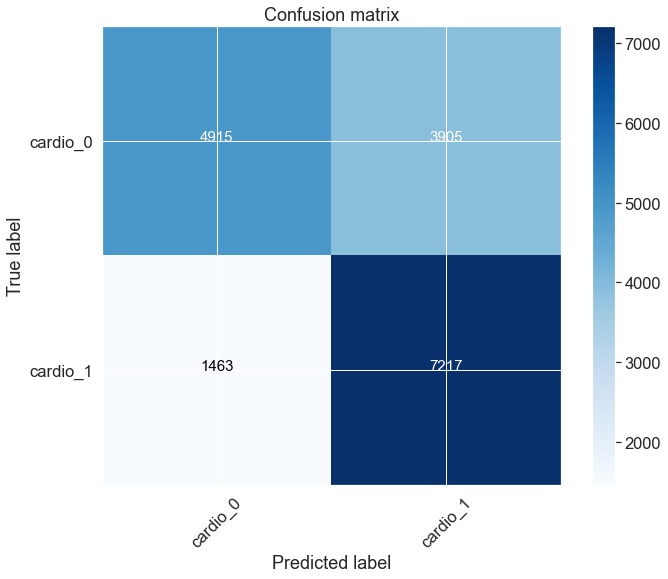

In [12]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>logreg[1])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [13]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.8314516129032258, 0.4427437641723356, 0.5572562358276644)

False Positive Rate довольно высокий ~ 0.44.

Это означает, что 44 процентов всех пациентов получат метку 1 при том, что они на самом деле здоровы

Следующий - градиентный бустинг

In [14]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingRegressor(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict(X_test)

CV score is 0.8021128900965708+-0.007510462669124107


Опять запишем метрики

In [15]:
gradboost = summary_metrics('GradientBoostingRegressor', y_score, y_test)

Нарисуем roc auc кривую

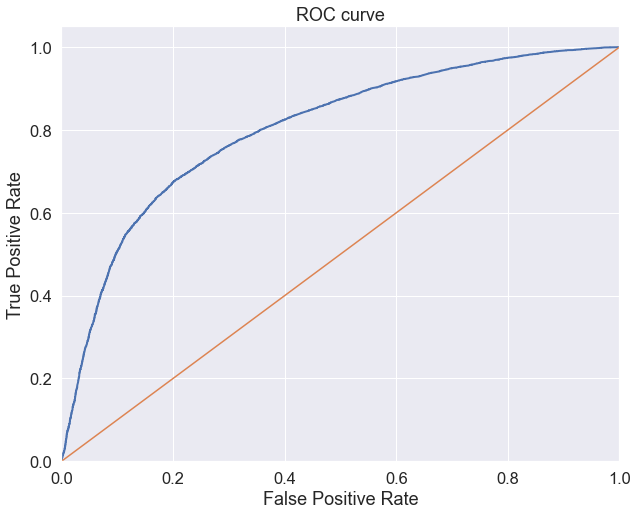

In [16]:
draw_roc_auc_curve(y_test, y_score)

Посмотрим на матрицу ошибок

Confusion matrix, without normalization
[[5624 3196]
 [1706 6974]]


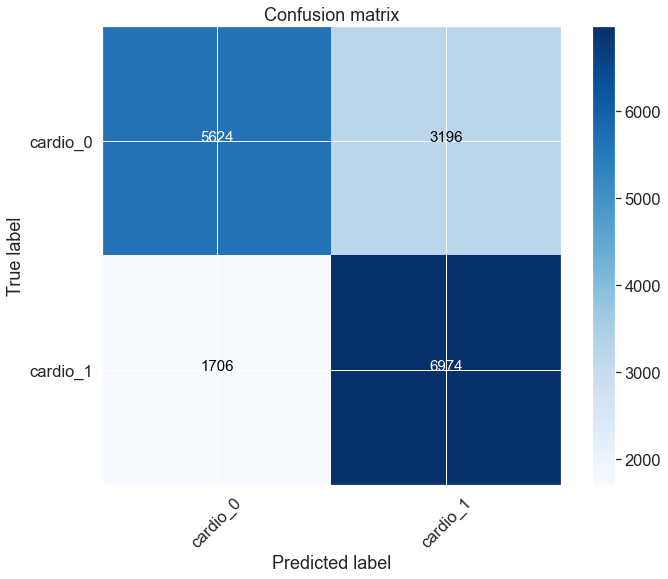

In [17]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>gradboost[1])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [18]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.8034562211981566, 0.36235827664399095, 0.6376417233560091)

Здесь результат лучше, False Positive Rate все же довольно высокий ~ 0.36.

И, наконец, случайный лес

In [19]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', RandomForestRegressor(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict(X_test)

CV score is 0.7703465596548783+-0.007113393750287115


Еще раз метрики

In [20]:
rfreg = summary_metrics('RandomForestRegressor', y_score, y_test)

Нарисуем roc auc кривую

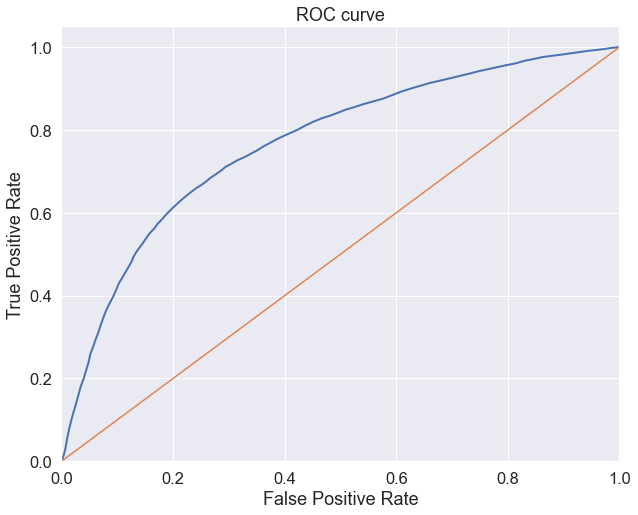

In [21]:
draw_roc_auc_curve(y_test, y_score)

Посмотрим на матрицу ошибок

Confusion matrix, without normalization
[[4965 3855]
 [1643 7037]]


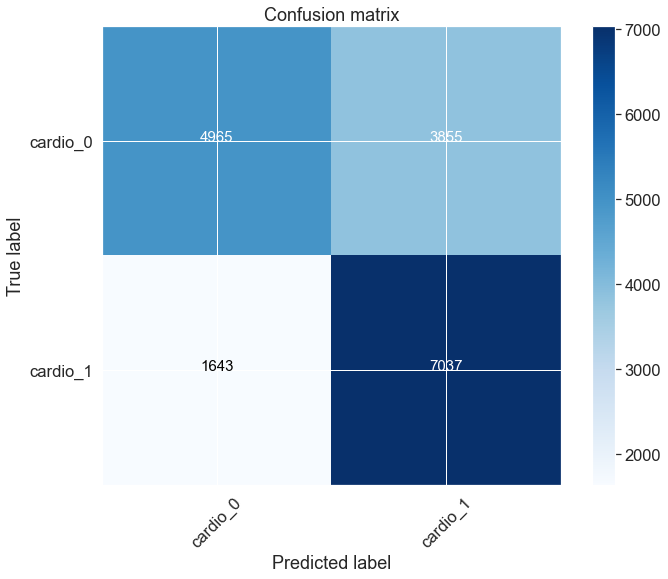

In [22]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>rfreg[1])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [23]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.8107142857142857, 0.4370748299319728, 0.5629251700680272)

Результат немного лучше, чем в LR

Построим сводную таблицу

In [24]:
def print_summary_table(data, cell_sep=' | ', header_separator=True):
    rows = len(data)
    cols = len(data[0])

    col_width = []
    for col in range(cols):
        columns = [data[row][col] for row in range(rows)]
        col_width.append(len(max(columns, key=len)))

    separator = "-+-".join('-' * n for n in col_width)

    for i, row in enumerate(range(rows)):
        if i == 1 and header_separator:
            print(separator)

        result = []
        for col in range(cols):
            item = data[row][col].rjust(col_width[col])
            result.append(item)

        print(cell_sep.join(result))

In [25]:
logreg_str = [str(item) for item in logreg]
gradboost_str = [str(item) for item in gradboost]
rfreg_str = [str(item) for item in rfreg]

In [26]:
table_data = [
        ['NAME', 'THRESHOLDS', 'FSCORE', 'PRECISION', 'RECALL', 'ROC_AUC_SCORE', 'LOG_LOSS'],
        logreg_str,
        gradboost_str,
        rfreg_str,
    ]

print_summary_table(table_data)

                     NAME | THRESHOLDS | FSCORE | PRECISION | RECALL | ROC_AUC_SCORE | LOG_LOSS
--------------------------+------------+--------+-----------+--------+---------------+---------
       LogisticRegression |       0.39 |   0.73 |      0.65 |   0.84 |          0.78 |     0.58
GradientBoostingRegressor |       0.38 |   0.74 |      0.68 |   0.81 |           0.8 |     0.54
    RandomForestRegressor |       0.35 |   0.72 |      0.64 |   0.82 |          0.77 |     0.61


Вывод: В данном случае лучше всего себя проявил градиентный бустинг в плане точности предсказания, но логистическая регрессия показывает большую полноту

Какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

roc_auc_curve будет не очень информативна, так как на графике мы отладываем m единиц по оси y и n единиц по оси x, где m и n это количество объектов в соответствующих классах. То есть при дисбалансе указанном в задаче ниже, на графике по факту мы увидим прямую проходящую практически по одной из осей.

В таких случаях лучше выбрать precision_recall_curve


#### Задача
Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

#### Ответ
Конечно, первая лучше и легче это проверить по precision_recall_curve.

Рассмотрим случай с ROC_AUC:

1 model
TPR = TP/(TP+FN) = 90/(90+10) = 0.9
FPR = FP/(FP+TN) = 10/99900 = 0.0001

2 model
TPR = 90/100  = 0.9
FPR = 910/99900 = 0.0091

Разница видна, но не очень явно

Рассмотрим случай с precision_recall:

1 model
precision = TP/(TP+FP) = 90/(90+10) = 0.9
recall = TP/(FN+TP) = 90/(90+10) = 0.9

2 model
precision = 90/1000  = 0.09
recall = 90/100 = 0.9

Здесь сразу видно ухудшение во второй модели.
